In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width: 98% }<\style>")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
activities_train = pd.read_csv('../data/act_train.csv.zip', index_col='activity_id', parse_dates=['date'])
activities_test = pd.read_csv('../data/act_test.csv.zip', index_col='activity_id', parse_dates=['date'])
people = pd.read_csv('../data/people.csv.zip', parse_dates=['date'])

In [4]:
print('People from train: ', activities_train.people_id.unique().size)
print('People from test: ', activities_test.people_id.unique().size)

print('People from intersection: ', np.intersect1d(activities_train.people_id.unique(), 
                                                   activities_test.people_id.unique()).size)

People from train:  151295
People from test:  37823
People from intersection:  0


In [5]:
people_from_train = activities_train.people_id.unique()
people_from_test = activities_test.people_id.unique()

people_from_void = people.people_id[~people.people_id.isin(np.hstack((people_from_train, people_from_test)))].values

print('People from void:', people_from_void.size)

People from void: 0


In [4]:
train = pd.merge(activities_train[['people_id', 'outcome', 'date']], 
                 people, 
                 on='people_id', 
                 right_index=True)

test = pd.merge(activities_test[['people_id', 'date']], 
                 people, 
                 on='people_id', 
                 right_index=True)

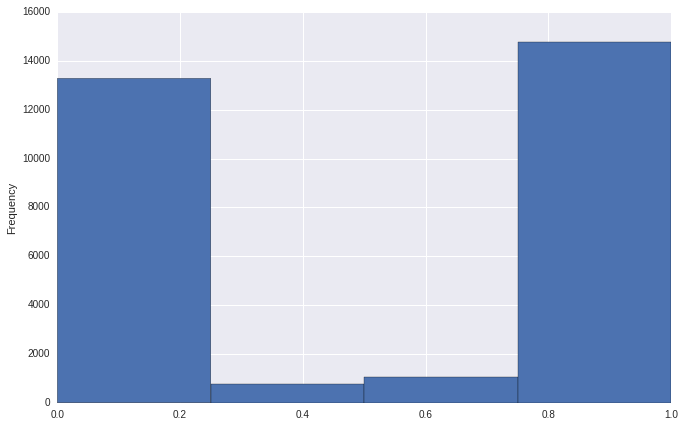

In [47]:
train.groupby('group_1')['outcome'].mean().plot.hist(figsize=(11, 7), bins=4)

In [55]:
print('Groups from train: ', train.group_1.unique().size) 
print('Groups from test: ', test.group_1.unique().size)
print('Groups from intersection: ', np.intersect1d(test.group_1.unique(), train.group_1.unique()).size) 

Groups from train:  29899
Groups from test:  11640
Groups from intersection:  7315


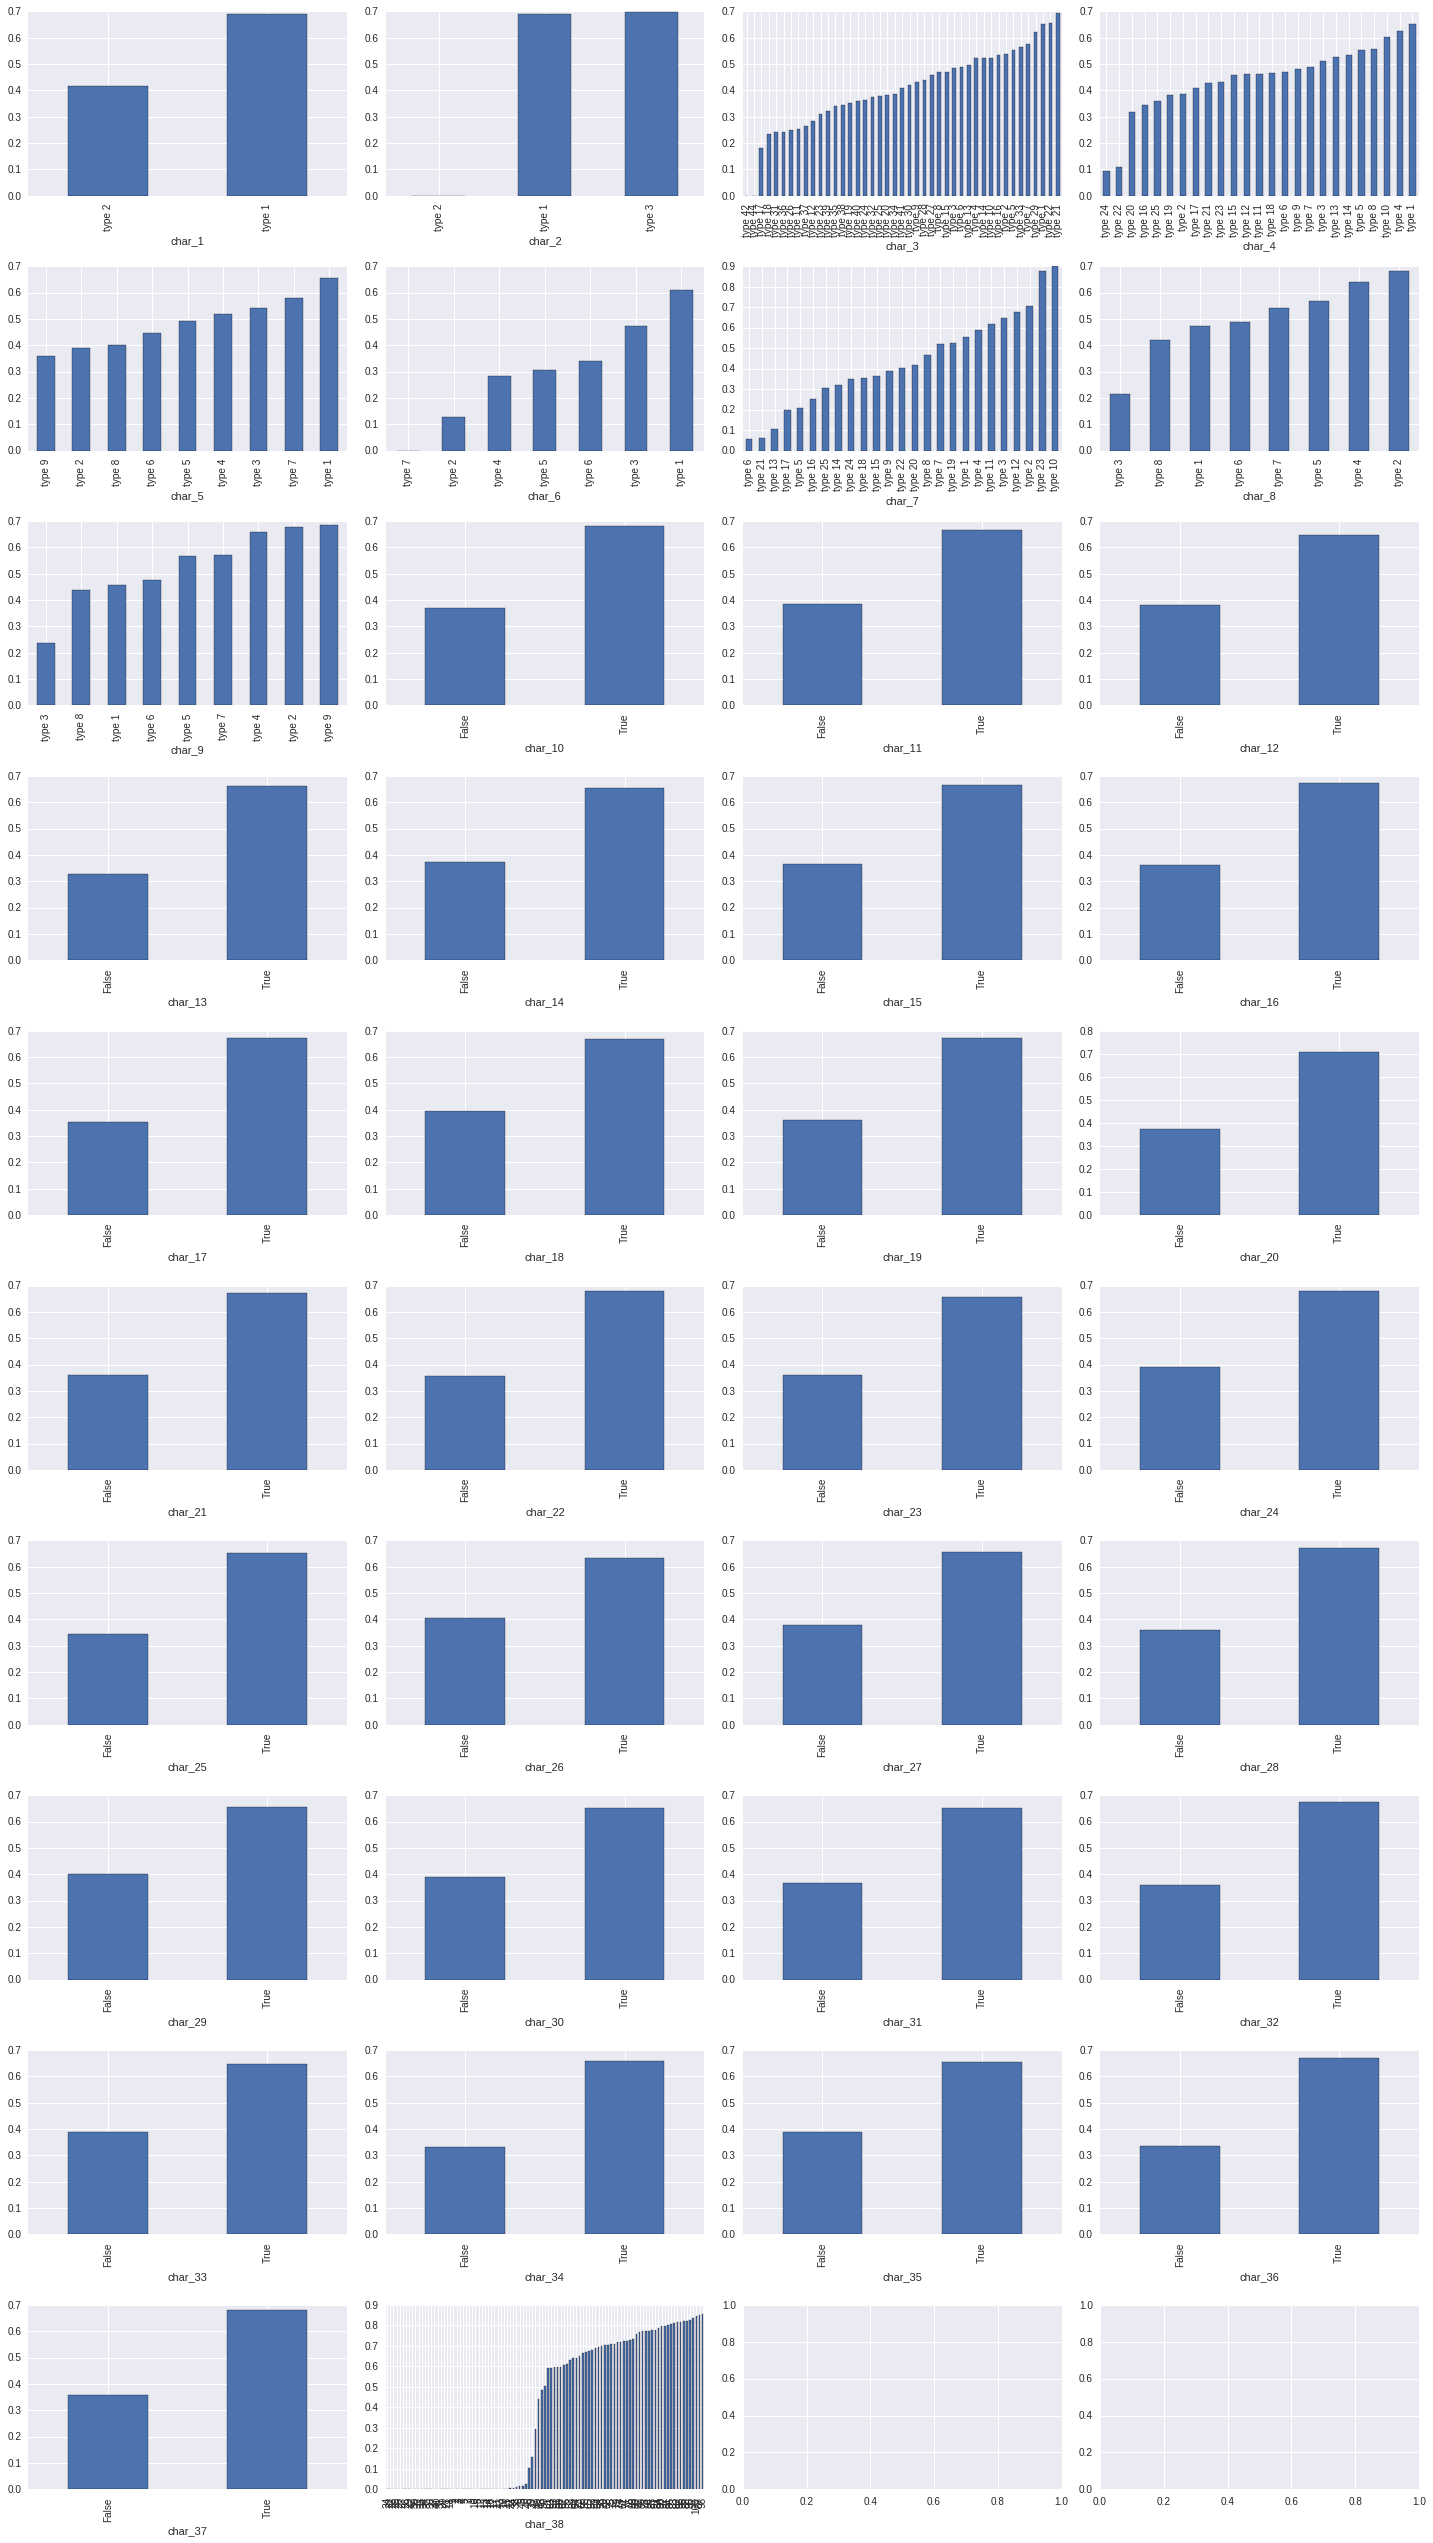

In [38]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(20, 35))

plt.tight_layout(h_pad=5)

for i, column_name in enumerate(train.columns[train.columns.str.startswith('char')]):
    train.groupby(column_name)['outcome'].mean().sort_values().plot(kind='bar', 
                                                                    ax=axs[np.unravel_index(i, (10, 4))])

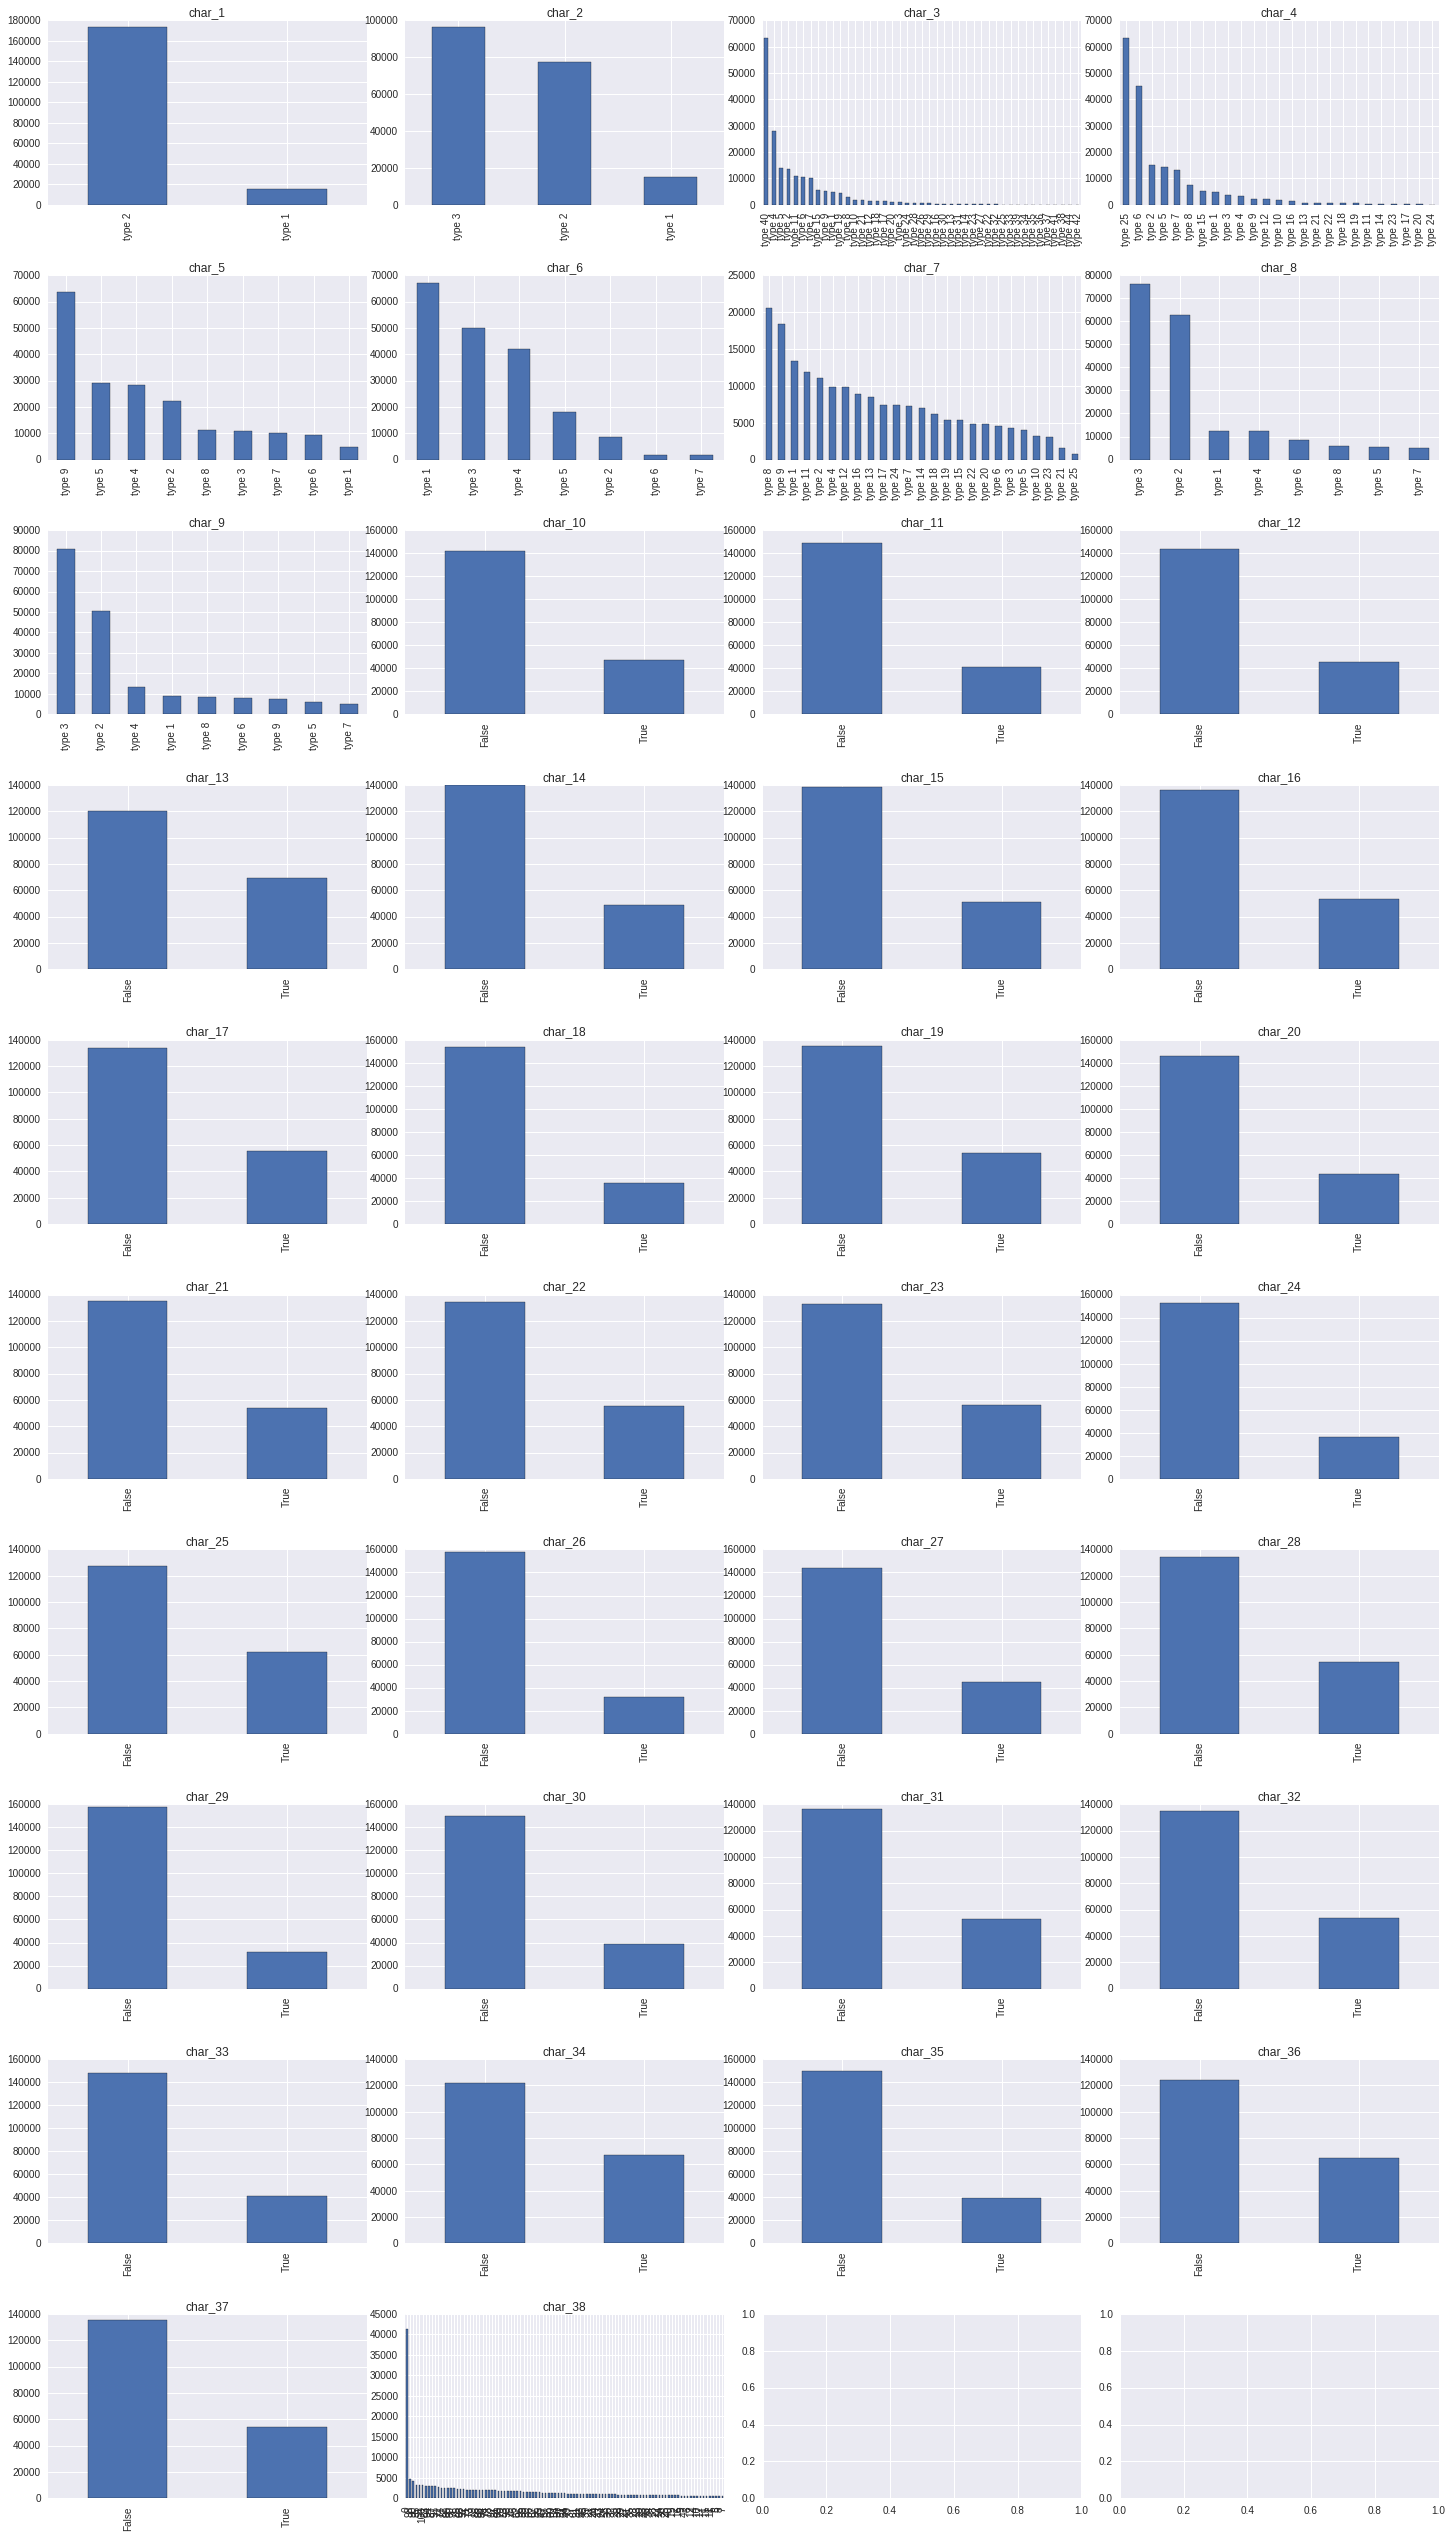

In [37]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(20, 35))

plt.tight_layout(h_pad=5)

for i, column_name in enumerate(people.columns[people.columns.str.startswith('char')]):
    people[column_name].value_counts().plot(kind='bar', 
                                            title=column_name,
                                            ax=axs[np.unravel_index(i, (10, 4))])

In [5]:
binary_columns = people.columns[people.columns.str.startswith('char')][9:-1]
reduced_people = people.set_index('people_id')[binary_columns].astype(np.int8)

In [6]:
reduced_people = reduced_people.drop_duplicates()

In [90]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(reduced_people, metric='cosine')

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_iter=500, random_state=45, metric='hamming')
y = tsne.fit_transform(reduced_people)

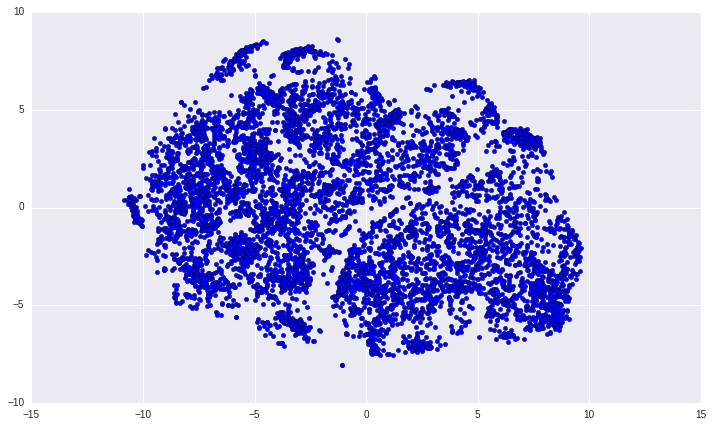

In [20]:
ax = plt.scatter(y[:, 0], y[:, 1])
ax.figure.set_size_inches(12, 7)

In [6]:
from misc import encode_cat_feature_using_targets, make_submission
from sklearn.metrics import roc_auc_score

for default_prob in np.linspace(0.1, 0.5, 10):
    encoded_group_1 = encode_cat_feature_using_targets(train.group_1, 
                                                       train.outcome, 
                                                       test.group_1, 
                                                       default_prob=default_prob, 
                                                       n_folds=5, 
                                                       random_state=45)
    make_submission(encoded_group_1, path='../submissions/only_group_1_submission.csv', index=test.index, name='outcome')

    auc = roc_auc_score(train.outcome, encoded_group_1)
    
    print('Prob = {prob}, AUC = {auc}'.format(prob=default_prob, auc=auc))

Prob = 0.1, AUC = 0.9708361531367453
Prob = 0.14444444444444446, AUC = 0.9709311935633832
Prob = 0.18888888888888888, AUC = 0.9711062949826639
Prob = 0.23333333333333334, AUC = 0.9713048112365088
Prob = 0.2777777777777778, AUC = 0.9713135928440594
Prob = 0.32222222222222224, AUC = 0.9712793182002095
Prob = 0.3666666666666667, AUC = 0.9712560008220182
Prob = 0.4111111111111111, AUC = 0.9711336771727526
Prob = 0.4555555555555556, AUC = 0.970931458514769
Prob = 0.5, AUC = 0.970723807641881


In [7]:
encoded_group_1 = encode_cat_feature_using_targets(train.group_1, 
                                                       train.outcome, 
                                                       test.group_1, 
                                                       default_prob=0.23, 
                                                       n_folds=5, 
                                                       random_state=45)

outcome
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: char_38, dtype: object

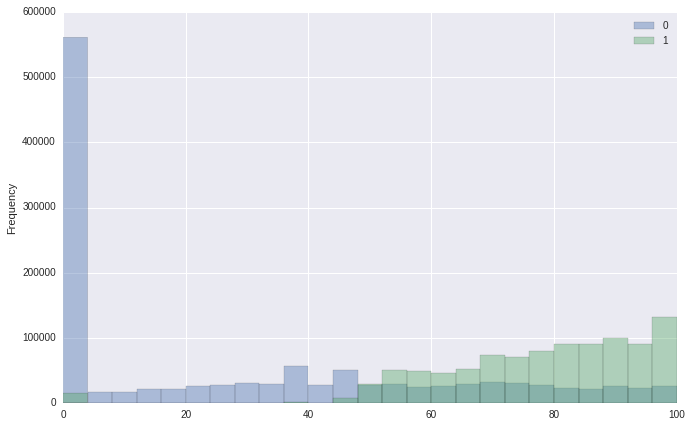

In [25]:
train.groupby('outcome')['char_38'].plot.hist(bins=25, figsize=(11, 7), alpha=0.4, legend=True)

In [65]:
for a in np.linspace(0.99, 1, 10):
    auc = roc_auc_score(train.outcome, (1 - a) * train.char_38 + a * encoded_group_1)
    
    print("a = {a}, AUC = {auc}".format(a=a, auc=auc))

a = 0.99, AUC = 0.9691915037299612
a = 0.991111111111111, AUC = 0.9702895260627556
a = 0.9922222222222222, AUC = 0.9714669967661426
a = 0.9933333333333333, AUC = 0.9726653254649922
a = 0.9944444444444445, AUC = 0.9740412698315223
a = 0.9955555555555555, AUC = 0.9752347056518423
a = 0.9966666666666667, AUC = 0.9758209534311691
a = 0.9977777777777778, AUC = 0.9764914417213899
a = 0.9988888888888889, AUC = 0.9766877671634556
a = 1.0, AUC = 0.9712996525444929


In [8]:
mean_outcomes = train.groupby('people_id')['outcome'].mean()

zero_one_means = mean_outcomes.compress((mean_outcomes == 0) | (mean_outcomes == 1)).index.to_series()
mixed_means = mean_outcomes.compress((mean_outcomes > 0) & (mean_outcomes < 1)).index.to_series()

In [68]:
print('Mixed:', roc_auc_score(train.outcome[train.people_id.isin(mixed_means)], train.char_38[train.people_id.isin(mixed_means)]))
print('Zero-Ones:', roc_auc_score(train.outcome[train.people_id.isin(zero_one_means)], train.char_38[train.people_id.isin(zero_one_means)]))

Mixed: 0.657862311468
Zero-Ones: 0.908424603374


In [69]:
print('Mixed:', roc_auc_score(train.outcome[train.people_id.isin(mixed_means)], encoded_group_1[train.people_id.isin(mixed_means)]))
print('Zero-Ones:', roc_auc_score(train.outcome[train.people_id.isin(zero_one_means)], encoded_group_1[train.people_id.isin(zero_one_means)]))

Mixed: 0.705116614453
Zero-Ones: 0.990505481192


In [9]:
train_for_mixed = train[train.people_id.isin(mixed_means)]
train_for_zero_ones = train[train.people_id.isin(zero_one_means)]

In [38]:
people_changes = pd.Series()

for person, actions in train_for_mixed.groupby('people_id').groups.items():
    person_outcome = train_for_mixed.loc[actions, ['outcome', 'date']].sort_values('date')['outcome']
    number_changes = np.count_nonzero(np.convolve(person_outcome.values, [1, -1], mode='valid'))
    
    people_changes[person] = number_changes

In [40]:
people_changes.value_counts()

1    5994
2     661
3       1
dtype: int64

In [43]:
one_changes = people_changes.index[people_changes == 1]

In [44]:
train_for_mixed_one_change = train_for_mixed[train_for_mixed.people_id.isin(one_changes)]

In [65]:
activities_train

,people_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
activity_id,,,,,,,,,,,,,,
act2_1734928,ppl_100,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
act2_2434093,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_3404049,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_3651215,ppl_100,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_4109017,ppl_100,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_898576,ppl_100,2023-08-04,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1727,0
act2_1233489,ppl_100002,2022-11-23,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
act2_1623405,ppl_100002,2022-11-23,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
act2_1111598,ppl_100003,2023-02-07,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1


In [71]:
date_change = pd.Series()

for person, actions in train_for_mixed_one_change.groupby('people_id').groups.items():
    person_outcome = train_for_mixed.loc[actions, ['outcome', 'date']].sort_values('date')
    
    if person_outcome.outcome.iloc[0] == 0:
        date_change[person_outcome.date[person_outcome.outcome.argmax()]] = 0
    else:
        date_change[person_outcome.date[person_outcome.outcome.argmin()]] = 1

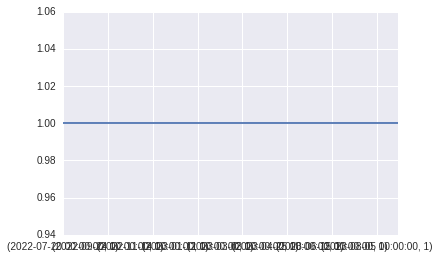

In [81]:
date_change[:] = 1
date_change.groupby(level=0).value_counts().plot()